[View in Colaboratory](https://colab.research.google.com/github/garybake/kaggle_entries/blob/master/CrimPredict.ipynb)

# Criminality Prediction

https://www.hackerearth.com/challenge/competitive/predict-the-criminal/machine-learning/predict-the-criminal/

Notes on field names  
https://www.icpsr.umich.edu/icpsrweb/NAHDAP/studies/04373/datasets/0001/variables/ANALWT_C?archive=nahdap

### Problem Statement

There has been a surge in crimes committed in recent years, making crime a top cause of concern for law enforcement. If we are able to estimate whether someone is going to commit a crime in the future, we can take precautions and be prepared. You are given a dataset containing answers to various questions concerning the professional and private lives of several people. A few of them have been arrested for various small and large crimes in the past. Use the given data to predict if the people in the test data will commit a crime. The train data consists of 45718 rows, while the test data consists of 11430 rows.

Using keras. I don't think a neural network is the ideal method for this problem, more I wanted to use it to aid my learning of keras.  

Initially I ran it using jupyter notes, then switched to the new jupyter labs and was impressed, then moved to google colab for the final runs (this is awesome for running on a free gpu).

In [1]:
import numpy as np
import pandas as pd

from keras import models
from keras import layers
from keras import metrics
from keras import regularizers

import matplotlib.pyplot as plt

Using TensorFlow backend.


### Get Data

In [0]:
# Running locally
# df_train_orig = pd.read_csv('data/criminal_train.csv')
# df_test_orig = pd.read_csv('data/criminal_test.csv')

In [3]:
from google.colab import files
uploaded = files.upload()

Saving criminal_train.csv to criminal_train (1).csv
Saving criminal_test.csv to criminal_test (1).csv


In [5]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn]))) 

import io
df_train_orig = pd.read_csv(io.StringIO(uploaded['criminal_train.csv'].decode('utf-8')))
df_test_orig = pd.read_csv(io.StringIO(uploaded['criminal_test.csv'].decode('utf-8')))

User uploaded file "criminal_train.csv" with length 8253714 bytes
User uploaded file "criminal_test.csv" with length 2040958 bytes


In [0]:
# Take a copy so we don't have to keep reloading the data while playing with the data
import copy
df_train = copy.deepcopy(df_train_orig)
df_test = copy.deepcopy(df_test_orig)

We are using one-hot-encoding. 
However this could result in the train and test set ending up with difference columns.
A quick solution is to join the train and test set together and split after applying ohe.
Set Criminal to -1 to differentiate the 2 sets.  
_There are better ways of doing this_

In [0]:
df_test['Criminal'] = -1
df_both = pd.concat([df_train, df_test])

In [8]:
df_both.head()

,PERID,IFATHER,NRCH17_2,IRHHSIZ2,IIHHSIZ2,IRKI17_2,IIKI17_2,IRHH65_2,IIHH65_2,PRXRETRY,...,TOOLONG,TROUBUND,PDEN10,COUTYP2,MAIIN102,AIIND102,ANALWT_C,VESTR,VEREP,Criminal
0,25095143,4,2,4,1,3,1,1,1,99,...,1,2,1,1,2,2,3884.805998,40026,1,0
1,13005143,4,1,3,1,2,1,1,1,99,...,2,2,2,3,2,2,1627.108106,40015,2,1
2,67415143,4,1,2,1,2,1,1,1,99,...,2,2,2,3,2,2,4344.957980,40024,1,0
3,70925143,4,0,2,1,1,1,1,1,99,...,2,2,1,1,2,2,792.521931,40027,1,0
4,75235143,1,0,6,1,4,1,1,1,99,...,2,2,2,2,2,2,1518.118526,40001,2,0


In [9]:
print(df_both.shape)

(57148, 72)


### Process Data

### Feature engineering

I went through the definitions on the fields using the link (substituting the field name:
https://www.icpsr.umich.edu/icpsrweb/NAHDAP/studies/04373/datasets/0001/variables/ANALWT_C?archive=nahdap

**default**
Most of the fields look categorical

**to_dump**  
Fields I didn't feel neccasary, they were mostly metadata

**two_is zero**  
Fields with a yes no answer, where 2 is no. For ohe we can convert the no to a zero. (also converted nulls to zero - neural nets effectively handle zeros as nulls)

**is_numeric**  
Non categorical fields

A couple of fields looked ordinal (income fields) but I got a better score setting them to ordinal and pushing them through OHE.

In [0]:
to_dump = ['IIHHSIZ2','IIKI17_2','IIHH65_2','PRXRETRY','HLNVCOST','HLNVOFFR','HLNVREF','HLNVNEED','HLNVSOR','IIMCDCHP','IIMEDICR','IICHMPUS','IIPRVHLT','IIOTHHLT','IIINSUR4','IIFAMSOC','IIFAMSSI','IIFSTAMP','IIFAMPMT','IIFAMSVC','IIWELMOS','IIPINC3','IIFAMIN3','ANALWT_C','VESTR','VEREP']
two_is_zero =['IRMCDCHP','IRMEDICR','IRCHMPUS','IRPRVHLT','IROTHHLT','ANYHLTI2','IRINSUR4','OTHINS','IRFAMSOC','IRFAMSSI','IRFSTAMP','IRFAMPMT','IRFAMSVC','GOVTPROG']
is_numeric = ['HLCNOTMO', 'IRWELMOS']

In [0]:
# Dump the unneeded fields
all_cols = list(df_both)
for col in all_cols:
    if col in to_dump:
        df_both = df_both.drop(col, axis=1)

In [0]:

for col in df_both:
    if col != 'Criminal':

        # A lot of fields had the same 'no answer' mappings so set them all to zero
        df_both[col] = df_both[col].replace(-1, 0)  # Null
        df_both[col] = df_both[col].replace(85, 0)  # BAD DATA Logically assigned
        df_both[col] = df_both[col].replace(94, 0)  # DON'T KNOW
        df_both[col] = df_both[col].replace(97, 0)  # REFUSED
        df_both[col] = df_both[col].replace(98, 0)  # BLANK (NO ANSWER)
        df_both[col] = df_both[col].replace(99, 0)  # LEGITIMATE SKIP (Respondent answering)
        
        # Set the 'no' answers to zero
        if col in two_is_zero:
            df_both[col] = df_both[col].replace(2, 0)  # 'no' answers
        
        # Set the fields to categorical (do I need to do this?)
        if col not in is_numeric:
            df_both[col] = df_both[col].astype('category')
        else:
            # Normalise the other fields so all fields are between -/+ 1 standard deviation
            mean = df_both[col].mean(axis=0)
            df_both[col] -= mean
            std = df_both[col].std(axis=0)
            df_both[col] /= std

In [13]:
df_both.Criminal.value_counts()

 0    42543
-1    11430
 1     3175
Name: Criminal, dtype: int64

One hot encode all of the fields

In [14]:
# List of columns before OHE
df_both.columns[1:-1]

Index(['IFATHER', 'NRCH17_2', 'IRHHSIZ2', 'IRKI17_2', 'IRHH65_2', 'PRXYDATA',
       'MEDICARE', 'CAIDCHIP', 'CHAMPUS', 'PRVHLTIN', 'GRPHLTIN', 'HLTINNOS',
       'HLCNOTYR', 'HLCNOTMO', 'HLCLAST', 'HLLOSRSN', 'IRMCDCHP', 'IRMEDICR',
       'IRCHMPUS', 'IRPRVHLT', 'IROTHHLT', 'HLCALLFG', 'HLCALL99', 'ANYHLTI2',
       'IRINSUR4', 'OTHINS', 'CELLNOTCL', 'CELLWRKNG', 'IRFAMSOC', 'IRFAMSSI',
       'IRFSTAMP', 'IRFAMPMT', 'IRFAMSVC', 'IRWELMOS', 'IRPINC3', 'IRFAMIN3',
       'GOVTPROG', 'POVERTY3', 'TOOLONG', 'TROUBUND', 'PDEN10', 'COUTYP2',
       'MAIIN102', 'AIIND102'],
      dtype='object')

In [0]:
# Hold back the numeric fields from OHE
cat_cols = set(df_both.columns[1:-1])
for col in is_numeric:
    cat_cols.remove(col)

In [0]:
# Actually do the OHE
df_ohe = pd.get_dummies(df_both, columns=cat_cols)  # ignore perid and criminal column

In [0]:
# Put all the data back together with the new OHE fields
df_ohe['PERID'] = df_both.PERID
df_ohe['Criminal'] = df_both.Criminal
for col in is_numeric:
    df_ohe[col] = df_both[col]

In [18]:
print(df_ohe.shape)

(57148, 150)


In [19]:
df_ohe.columns

Index(['PERID', 'HLCNOTMO', 'IRWELMOS', 'Criminal', 'IRFAMPMT_0', 'IRFAMPMT_1',
       'IFATHER_0', 'IFATHER_1', 'IFATHER_2', 'IFATHER_3',
       ...
       'MAIIN102_2', 'IRFSTAMP_0', 'IRFSTAMP_1', 'PRXYDATA_0', 'PRXYDATA_1',
       'PRXYDATA_2', 'IRFAMSOC_0', 'IRFAMSOC_1', 'IRCHMPUS_0', 'IRCHMPUS_1'],
      dtype='object', length=150)

Split the data back into train and test sets

In [0]:
df_train = df_ohe[df_ohe['Criminal'] != -1]
df_test = df_ohe[df_ohe['Criminal'] == -1]

In [21]:
df_train_labels = df_train['Criminal']
# Drop the PERID field as we shouldn't predict from it
# Also drop the Criminal field else our model will just use this!
df_train = df_train.drop(['PERID','Criminal'], axis = 1)
print(df_train.shape)

(45718, 148)


In [0]:
# Remove the Criminal column from the test set
df_test = df_test.drop(['Criminal'], axis = 1)

In [23]:
print(df_train.shape)
print(df_test.shape)

(45718, 148)
(11430, 149)


### Convert for Keras

Keras deals with numpy arrays rather than pandas dataframes so we do a little bit of conversion

In [0]:
# Get the base arrays using the values from the dataframes
labels = df_train_labels.values
data = df_train.values

In [0]:
# TODO: do I need to do this step?
# Convert from ints to floats
labels = labels.astype(np.float32, copy=False)
data = data.astype(np.float32, copy=False)

In [26]:
print(data.shape)
print(labels.shape)

(45718, 148)
(45718,)


Split the training data into a train and test set (the other test set is what we sumbit with)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.20, random_state=42)

# Build the model

In [0]:
# We need this to handle the unbalanced data
# https://github.com/keras-team/keras/issues/1875
# TODO: I don't think I need to do this
def get_class_weights(y, smooth_factor=0):
    """
    Returns the weights for each class based on the frequencies of the samples
    :param smooth_factor: factor that smooths extremely uneven weights
    :param y: list of true labels (the labels must be hashable)
    :return: dictionary with the weight for each class
    """
    from collections import Counter
    counter = Counter(y)

    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p

    majority = max(counter.values())

    return {cls: float(majority) / count for cls, count in counter.items()}

In [30]:
class_weights = get_class_weights(labels)
class_weights

{0.0: 1.0, 1.0: 13.399370078740157}

In [0]:
# Used as the evaluation function
# Removed from older keras source due to it being inappropriate for batchings  
# use huge batches to compensate
import keras.backend as K
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

### Build the network

After the feature engineering this is the next largest amount of work.

I started with a couple of layers (64/31/1) and appropriate model parameters.

The problem is a binary classification which means we use binary_crossentropy as the loss and sigmoid activation on the last layer.  
Optimizer is rmsprop (TODO: check other optimizers)

I then iterated over hyperparams to find the best values, tuning each section before moving to the next:
1. Layers 
2. Number of epochs  
3. Batch_size  
4. Regularization (no effect)  

Then back through the loop to make sure the later settings hadn't changed the initial tunings.

In [0]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(148,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=[matthews_correlation])

# Run the model

In [34]:
history = model.fit(data_train,
                   labels_train,
                   epochs=85,
                   class_weight = class_weights,
                   batch_size=10000,
                   verbose=0,
                   validation_data=(data_test, labels_test))
print('done')

done


### Evaluate the model

Using the history object we can get see what the state of the model was at each training step

In [0]:
matt = history.history['matthews_correlation']
val_matt = history.history['val_matthews_correlation']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(matt) + 1)

**Graph the loss**  
This is the total difference (accross all rows in batch) between the target and the ground truth.

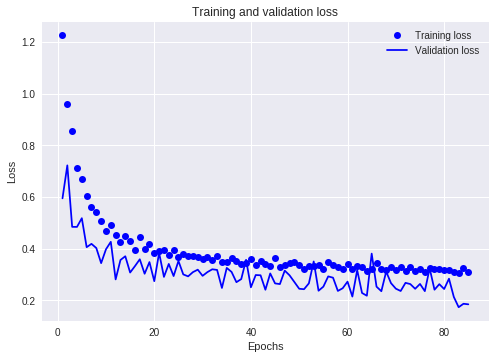

In [36]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Graph the accuracy**  
https://en.wikipedia.org/wiki/Matthews_correlation_coefficient  
Using matthews correlation coefficient, compares how many we predicted correctly compared to how many predicted incorrectly.  
A more useful measure than binary_crossentropy due to the weighted dataset we have.

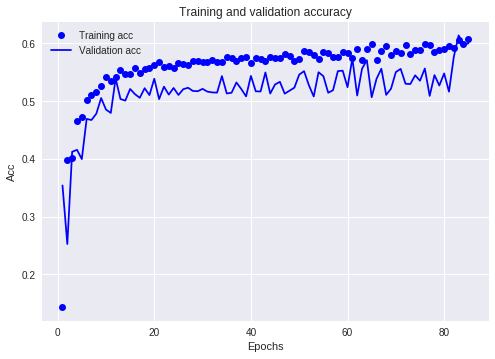

In [37]:
plt.plot(epochs, matt, 'bo', label='Training acc')
plt.plot(epochs, val_matt, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

The validation accuracy is all over the place so we plot a smoothed line to get a better idea of how the model is performing

In [0]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [0]:
smooth_history = smooth_curve(val_matt, factor=0.9)

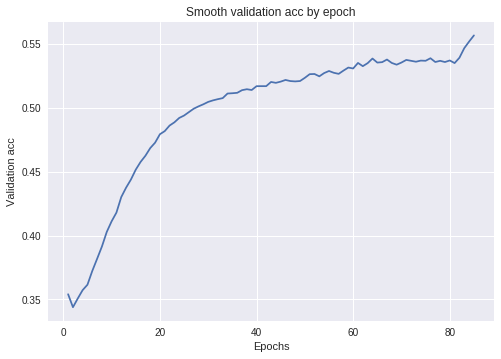

In [40]:
plt.plot(range(1, len(smooth_history) + 1), smooth_history)
plt.title('Smooth validation acc by epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation acc')
plt.show()

Run a test on all of the data to get a final accuracy score

In [41]:
test_loss, test_acc = model.evaluate(data, labels)

45718/45718 [==============================] - 4s 83us/step


We can use the test accuracy to get a good idea of the current performance of the model.  

In [42]:
test_acc

0.5748746381161005

**Importand step**  
Go back to 'build the model' and change one of the hyperparams. Incrementaly improving the accuracy score.  
With MCC:  
A value of 0 is the score we could expect my returning random values.  
A negative score means we are performing worse than random.  
A 1 means we are prediction every value correctly.  

### Submit our predictions

Get the predictions out of the model using the test data set. This contains all of the columns apart from 'Criminal', we are supposed to use our model to fill in this field.
(This code is messy and should be improved)

In [0]:
new_predict = copy.deepcopy(df_test)
vals = df_test.drop(['PERID'], axis = 1).values  # drop the PERID

In [0]:
# Run the model on the test data
predictions = model.predict(vals)

In [0]:
def split_val(v):
    if v > 0.5:
        return 1
    return 0

In [0]:
# Apply the function to each row and create a new predictions column
new_predict['predictions'] = [split_val(x) for x in predictions]

In [0]:
df_predict = new_predict[['PERID', 'predictions']]
df_predict=df_predict.rename(columns = {'predictions':'Criminal'})

In [79]:
df_predict.head()  # The submitted file should have just PERID and Criminal columns

,PERID,Criminal
0,66583679,0
1,35494679,0
2,79424679,0
3,11744679,0
4,31554679,0


In [0]:
# Export our predictions to csv
df_predict.to_csv('predictions.csv', sep=',', index=False)

In [0]:
# Download the csv file
files.download('predictions.csv')

# Afterthoughs

I thought it was an interesting problem. I went through all of the fields I could get definitions for and some where a bit hard to understand their meaning/significance.
The unbalanced data set as always was a struggle. This was the first time I've use MCC for to handle the accuracy and I can see the reasoning behind it.

I like Keras and once tuned gives a decent accuracy. I figured the top scores would be using something like xgboost as I've had decent success with it in the past on this sort of problem. When I ran some tests using xgboost on this data (using the same feature engineering) I could only get close but no better than the keras score. Even after a couple of hours tuning and using cross validation. 

I also tried a bit of a bit of ensembling, though only used 5 slightly different keras models so didn't get enough of a different set of predictions to make it work.

I like the new google colab (colab.research.google.com). (Apart from the file upload was a bit of a faf). My laptop has an ATI gpu which is rubbish for ML, so being able to run it on a free machine with a supported GPU improved how fast I could iterate through the training immensely. Incidentally with xgboost not currently supporting GPU I got a better performance on my laptop with its greater number of CPU cores.

I got a decent score in the competition (0.82038) though not good enough to get into the top tier.  
I still think xgboost is the way to get a better score, with some ensembling maybe from svm. 

I didn't spend much time looking at the spread of the values in each field, maybe getting a better representation of the data in batch could have helped.
Finally the removal of MCC from keras' metrics. I understand why it was removed from the metrics - it doesn't work well on batches of data and needs a full evaluation to give an accurate value. I figured I could work around it by using huge batches, though this still is something that I don't feel was optimal.